In [1]:
#libraries
import pandas as pd
import numpy as np
from plotnine import ggplot, aes, geom_point, geom_line
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



Our goal will be to fit models that identify the Sativa types from the Indica types, and then to fit models that also distinguish the Hybrid types.

IMPORTANT: In this assignment, you do not need to consider different feature sets. Normally, this would be a good thing to try - but for this homework, simply include all the predictors for every model.

In [2]:
# data set link:
# https://www.dropbox.com/s/s2a1uoiegitupjc/cannabis_full.csv

cannabis = pd.read_csv('data/cannabis_full.csv')


#remove effects and flavor columns

cannabis.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,Aroused,Happy,Uplifted,Hungry,Talkative,Giggly,Focused,Sleepy,Dry,Mouth,Earthy,Sweet,Citrus,Flowery,Violet,Diesel,Spicy/Herbal,Sage,Woody,Apricot,Grapefruit,Orange,Pungent,Grape,Pine,Skunk,Berry,Pepper,Menthol,Blue,Cheese,Chemical,Mango,Lemon,Peach,Vanilla,Nutty,Chestnut,Tea,Tobacco,Tropical,Strawberry,Blueberry,Mint,Apple,Honey,Lavender,Lime,Coffee,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
#deal with NA's
#get NA counts for each variable
na_counts = cannabis.isna().sum()
#print(na_counts)

#its terrible practice to delete all na's but in this case there are only around 160ish and our dataset has 2.3k observations so hopefully it wont impact the results that much
cannabis_clean = cannabis.dropna()

#must remove the original variables that were created our dummified variables of effects and flavor
cannabis_clean = cannabis_clean.drop(["Effects", "Flavor"], axis = 1)

In [4]:
#get counts of each class type
type_counts = cannabis_clean['Type'].value_counts()
print(type_counts)


Type
hybrid    1123
indica     659
sativa     409
Name: count, dtype: int64
Type
hybrid    1123
indica     659
sativa     409
Name: count, dtype: int64


**Part One: Binary Classification**

Create a dataset that is limited only to the Sativa and Indica type cannabis strains.

This section asks you to create a final best model for each of the four new model types studied this week: LDA, QDA, SVC, and SVM. For SVM, you may limit yourself to only the polynomial kernel.

For each, you should:

* Choose a metric you will use to select your model, and briefly justify your choice. (Hint: There is no specific target category here, so this should not be a metric that only prioritizes one category.)

* Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

* Report the (cross-validated!) metric.

* Fit the final model.

* Output a confusion matrix.

In [5]:
#dataset including only sativa and indica
cannabis_binary = cannabis_clean[(cannabis['Type'] == "sativa") | (cannabis_clean['Type'] == "indica")]

<positron-console-cell-5>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [6]:
#variable selection
X = cannabis_binary.drop(["Type"], axis = 1)
y = cannabis_binary["Type"]

In [7]:
#split to train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
#column transformer
ct = ColumnTransformer(
  [
    ("dummify", 
    #handle_unknown: ignore observations for unknown values in category variable
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize", 
    StandardScaler(), 
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

**Q1: LDA**

Metric Selection: because our variable is binary, accuracy is a valid scoring metric to use for LDA.

Although there is a slight imbalance between our two responses it is not necessary significant enough for us to want to change our scoring metric

In [9]:
#pipeline
lr_pipeline_linear_disc = Pipeline(
  [("preprocessing", ct),
  ("linear_disc_analysis", LinearDiscriminantAnalysis(solver = "lsqr", shrinkage = "auto"))]
).set_output(transform="pandas")

In [10]:
#hypertune
parameters = {
    "linear_disc_analysis__solver": ["svd", "lsqr", "eigen"],
    "linear_disc_analysis__shrinkage": [None, "auto", 0.1, 0.5, 0.9]}


gscv = GridSearchCV(lr_pipeline_linear_disc, parameters, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.

,linear_disc_analysis__shrinkage,linear_disc_analysis__solver,scores
4,auto,lsqr,0.864236
5,auto,eigen,0.864236
13,0.9,lsqr,0.863319
14,0.9,eigen,0.863319
10,0.5,lsqr,0.861432


In [11]:
#fit data using final model
lr_pipeline_linear_disc.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168f3ebd0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168f3edb0>)])),
                ('linear_disc_analysis',
                 LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'))])

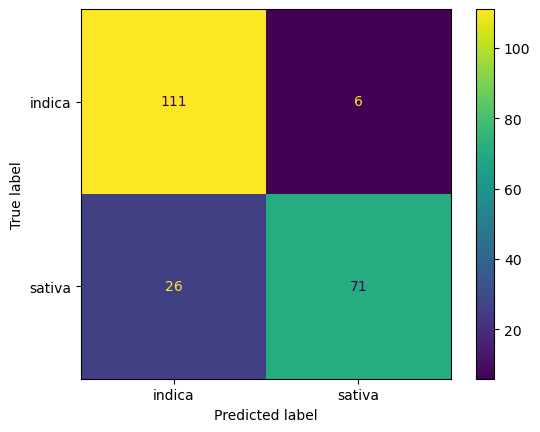

In [12]:
#get confusion matrix

# predict y's on X_test
y_pred = lr_pipeline_linear_disc.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
lda_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_pipeline_linear_disc.named_steps['linear_disc_analysis'].classes_)
lda_cm.plot()

# extract all the values from the confusion matrix
tn_lda, fp_lda, fn_lda, tp_lda = cm.ravel()

Because of there isn't a BIG imbalance within our data between indica and sativa observations AND our reponse variable is binary. it makes the most sense to use accuracy as the metric 

Although there is a slight imbalance between our two responses it is not necessary significant enough for us to want to change our scoring metric

**QDA**

In [13]:
#pipeline
lr_pipeline_quad_disc = Pipeline(
  [("preprocessing", ct),
  ("quad_disc_analysis", QuadraticDiscriminantAnalysis(reg_param = 1))]
).set_output(transform="pandas")

In [14]:
#hypertune
parameters = {
    "quad_disc_analysis__reg_param": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}


gscv = GridSearchCV(lr_pipeline_quad_disc, parameters, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


,quad_disc_analysis__reg_param,scores
10,1.0,0.851143
0,0.0,0.648037
9,0.9,0.625497
3,0.3,0.621723
2,0.2,0.618915


Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.

In [15]:
#fit data using final model
lr_pipeline_quad_disc.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168f3ebd0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168f3edb0>)])),
                ('quad_disc_analysis',
                 QuadraticDiscriminantAnalysis(reg_param=1))])

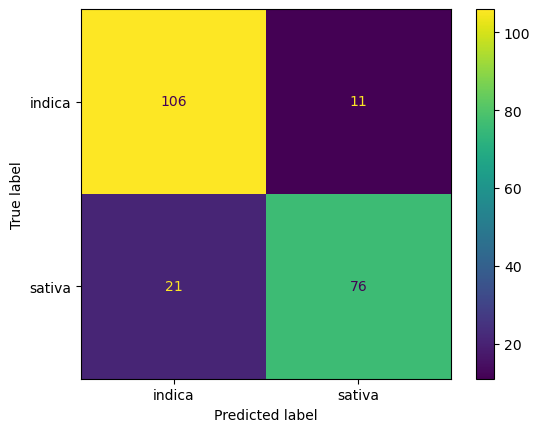

In [16]:
#get confusion matrix

# predict y's on X_test
y_pred = lr_pipeline_quad_disc.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
lda_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_pipeline_quad_disc.named_steps['quad_disc_analysis'].classes_)
lda_cm.plot()

# extract all the values from the confusion matrix
tn_lda, fp_lda, fn_lda, tp_lda = cm.ravel()

Because of there isn't a BIG imbalance within our data between indica and sativa observations AND our reponse variable is binary. it makes the most sense to use accuracy as the metric 

**SVC (linear)**

In [17]:
#pipeline
lr_pipeline_support_vector_class = Pipeline(
  [("preprocessing", ct),
  #use kernel = 'linear' like from practice activity, still want to tune C
  ("support_vector_class", SVC(C = 0.1, kernel = 'linear'))]
).set_output(transform="pandas")

In [18]:
#tune c
cs = {"support_vector_class__C": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_support_vector_class, cs, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,support_vector_class__C,scores
2,0.100,0.856746
1,0.010,0.853947
4,10.000,0.852073
5,100.000,0.852073
3,1.000,0.851143
0,0.001,0.851130


In [19]:
#fit data using final model
lr_pipeline_support_vector_class.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168f3ebd0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168f3edb0>)])),
                ('support_vector_class', SVC(C=0.1, kernel='linear'))])

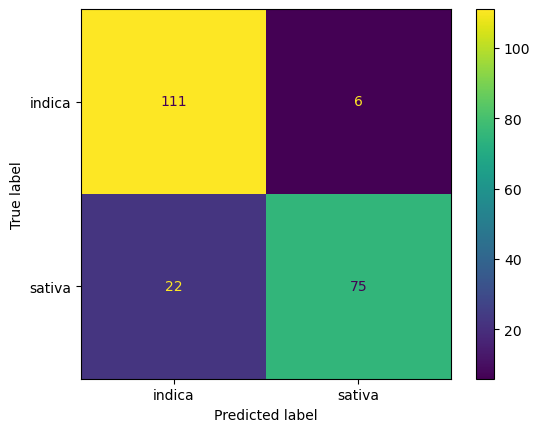

In [20]:
#get confusion matrix

# predict y's on X_test
y_pred = lr_pipeline_support_vector_class.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
lda_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_pipeline_support_vector_class.named_steps['support_vector_class'].classes_)
lda_cm.plot()

# extract all the values from the confusion matrix
tn_lda, fp_lda, fn_lda, tp_lda = cm.ravel()

Because of there isn't a BIG imbalance within our data between indica and sativa observations AND our reponse variable is binary. it makes the most sense to use accuracy as the metric.

Although there is a slight imbalance between our two responses it is not necessary significant enough for us to want to change our scoring metric

**SVM (non-linear)**

In [21]:
#pipeline
lr_pipeline_support_vector_machine = Pipeline(
  [("preprocessing", ct),
  #use kernel = 'linear' like from practice activity, still want to tune C
  ("support_vector_machine", SVC(C = 1, kernel = 'rbf'))]
).set_output(transform="pandas")

In [22]:
#tune c
cs = {"support_vector_machine__C": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_support_vector_machine, cs, cv = 5, scoring='accuracy')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,support_vector_machine__C,scores
3,1.000,0.841810
4,10.000,0.831495
5,100.000,0.825883
2,0.100,0.791229
0,0.001,0.617042
1,0.010,0.617042


In [23]:
#fit data using final model
lr_pipeline_support_vector_machine.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168f3ebd0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168f3edb0>)])),
                ('support_vector_machine', SVC(C=1))])

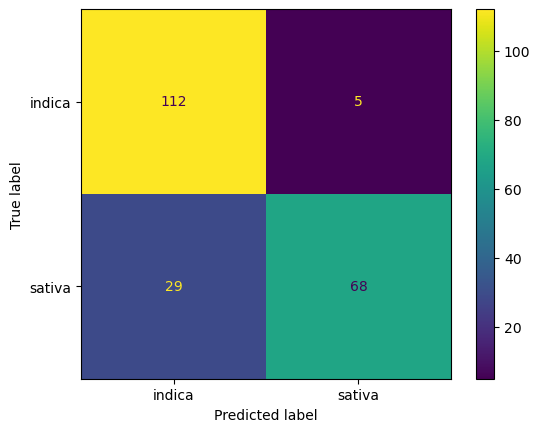

In [24]:
#get confusion matrix

# predict y's on X_test
y_pred = lr_pipeline_support_vector_machine.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
lda_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_pipeline_support_vector_machine.named_steps['support_vector_machine'].classes_)
lda_cm.plot()

# extract all the values from the confusion matrix
tn_lda, fp_lda, fn_lda, tp_lda = cm.ravel()

Because of there isn't a BIG imbalance within our data between indica and sativa observations AND our reponse variable is binary. it makes the most sense to use accuracy as the metric 

Although there is a slight imbalance between our two responses it is not necessary significant enough for us to want to change our scoring metric

**Part Two: Natural Multiclass**

Now use the full dataset, including the Hybrid strains.

In [25]:
#variable selection
X = cannabis_clean.drop(["Type"], axis = 1)
y = cannabis_clean["Type"]

In [26]:
#split to train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Q1**

Fit a decision tree, plot the final fit, and interpret the results.

In [27]:
#decision tree pipeline
decision_tree_pipeline = Pipeline([
    ("preprocessing", ct),
    ("decision_tree_classifier", DecisionTreeClassifier(ccp_alpha = .01))
]).set_output(transform = "pandas")

In [28]:
#tune c
cs = {"decision_tree_classifier__ccp_alpha": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(decision_tree_pipeline, cs, cv = 5, scoring='f1_macro')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,decision_tree_classifier__ccp_alpha,scores
0,0.001,0.530798
1,0.010,0.449010
2,0.100,0.225910
3,1.000,0.225910
4,10.000,0.225910
5,100.000,0.225910


In [29]:
#fit tree
decision_tree_pipeline.fit(X,y)

tree = decision_tree_pipeline.named_steps['decision_tree_classifier']

[Text(0.6, 0.8333333333333334, 'standardize__Sleepy <= 0.367\ngini = 0.612\nsamples = 2191\nvalue = [1123, 659, 409]\nclass = hybrid'),
 Text(0.4, 0.5, 'standardize__Energetic <= 0.481\ngini = 0.55\nsamples = 1473\nvalue = [889.0, 203.0, 381.0]\nclass = hybrid'),
 Text(0.2, 0.16666666666666666, 'gini = 0.507\nsamples = 884\nvalue = [581, 179, 124]\nclass = hybrid'),
 Text(0.6, 0.16666666666666666, 'gini = 0.535\nsamples = 589\nvalue = [308.0, 24.0, 257.0]\nclass = hybrid'),
 Text(0.8, 0.5, 'gini = 0.489\nsamples = 718\nvalue = [234.0, 456.0, 28.0]\nclass = indica')]

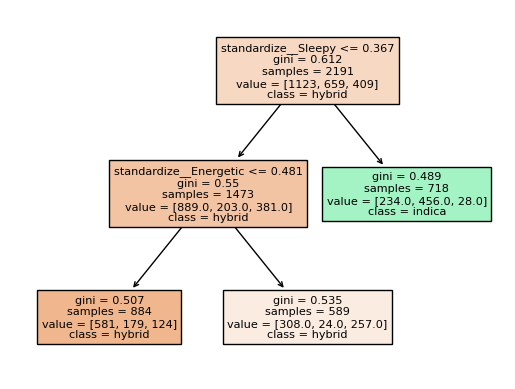

In [30]:
#names from the preprocessing step
feature_names = ct.get_feature_names_out()
# target class names
class_names = tree.classes_.astype(str)

plot_tree(
    tree,
    #names from the preprocessing step
    feature_names=feature_names, 
    # target class names
    class_names=class_names, 
    # color nodes by class
    filled=True,
)


For the metric I decided to use f1-macro (weighted f1 would be okay too). This is because we observe an imbalance in our three classes. This ensures that there is equal importance for all classes regardless of their observation count in our dataset, this will help us avoid bias.

After tuning our decision regression we got a f1-macro score of .530 so our decision tree model is not amazing, but considering that there are 3 classes, it is still well above the strength of guessing. Additionally, because we used f1-macro as our metric it is accounting for any imbalances we might have in our data.

From our tree we can see that the sleepy was a key variable in detmerining the class as indica, but other than that there weren't really any other vactors that could easily help us differentiate the three classes from eachother. As a result hybrid was the class identifier for every other branch in this model as it has many identifying features that the indica and sativa have. 

As a result we can say that it is easier to distinguish sativa and indica from each other, but much more difficult to distinguish sativa, hybrid, and indica from eachother

**Q2**

Repeat the analyses from Part One for LDA, QDA, and KNN.

**LDA**

In [31]:
#pipeline
lr_pipeline_linear_disc = Pipeline(
  [("preprocessing", ct),
  ("linear_disc_analysis", LinearDiscriminantAnalysis())]
).set_output(transform="pandas")

In [32]:
#hypertune
parameters = {
    "linear_disc_analysis__solver": ["svd", "lsqr", "eigen"],
    "linear_disc_analysis__shrinkage": [None, "auto", 0.1, 0.5, 0.9]}


gscv = GridSearchCV(lr_pipeline_linear_disc, parameters, cv = 5, scoring='f1_macro')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
27 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.

,linear_disc_analysis__shrinkage,linear_disc_analysis__solver,scores
4,auto,lsqr,0.601772
5,auto,eigen,0.601772
7,0.1,lsqr,0.596132
8,0.1,eigen,0.596132
10,0.5,lsqr,0.594796


In [33]:
#fit data using final model
lr_pipeline_linear_disc.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168f3ebd0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168f3edb0>)])),
                ('linear_disc_analysis', LinearDiscriminantAnalysis())])

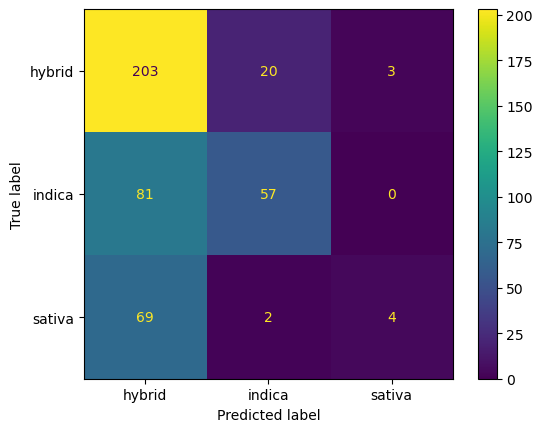

In [34]:
#get confusion matrix

# predict y's on X_test
y_pred = lr_pipeline_linear_disc.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
lda_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_pipeline_linear_disc.named_steps['linear_disc_analysis'].classes_)
lda_cm.plot()


The metric used in this model was f1-macro. This is because our we have a multiclass variable as our response. Additionally, from our counts shown at the start of the lab, we can see that there is a BIG imbalance in between our classes (where hybrid is almost half of the observations). Becuase of this we want to use f1-macro as it will score for each class independently and then average them. This will give each class an equal weight.

**QDA**

In [35]:
#pipeline
lr_pipeline_quad_disc = Pipeline(
  [("preprocessing", ct),
  ("quad_disc_analysis", QuadraticDiscriminantAnalysis())]
).set_output(transform="pandas")

In [36]:
#fit data using final model
lr_pipeline_quad_disc.fit(X_train, y_train)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168f3ebd0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168f3edb0>)])),
                ('quad_disc_analysis', QuadraticDiscriminantAnalysis())])

In [37]:
#cross validated score
scores = cross_val_score(lr_pipeline_quad_disc, X, y, cv=5, scoring='f1')

scores.mean()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_response.py", line 203, in _get_response_values
    raise ValueError(
ValueError: pos_label=1 is not a valid label: It should be one of ['hybrid' 'indica' 'sativa']



/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_response.py", line 203, in _get_response_values
    raise ValueError(
ValueError: pos_label=1 is not a valid label: It should be one of ['hybrid' 'indica' 'sativa']



/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_response.py", line 203, in _get_response_values
    raise ValueError(
ValueError: pos_label=1 is not a valid label: It should be one of ['hybrid' 'indica' 'sativa']



/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_response.py", line 203, in _get_response_values
    raise ValueError(
ValueError: pos_label=1 is not a valid label: It should be one of ['hybrid' 'indica' 'sativa']



/opt/anaconda3/lib/python3.12/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 87, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_response.py", line 203, in _get_response_values
    raise ValueError(
ValueError: pos_label=1 is not a valid label: It should be one of ['hybrid' 'indica' 'sativa']



nan

In [38]:
# predict y's on X_test
y_pred = lr_pipeline_quad_disc.predict(X_test)

# Calculate the weighted F1 score
weighted_f1 = f1_score(y_test, y_pred, average='weighted')

print("Weighted F1 Score: ", weighted_f1)

Weighted F1 Score:  0.328809249836504
Weighted F1 Score:  0.328809249836504


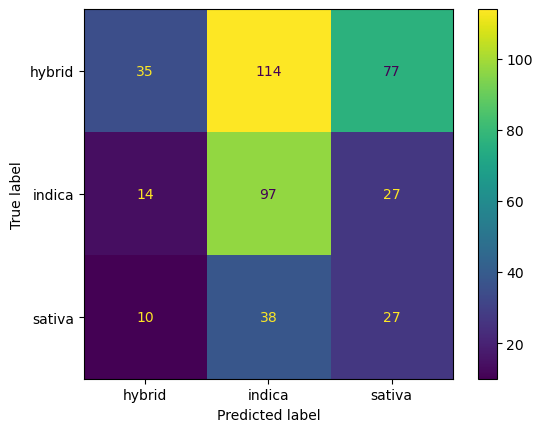

In [39]:
#get confusion matrix

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
lda_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_pipeline_quad_disc.named_steps['quad_disc_analysis'].classes_)
lda_cm.plot()

The metric used in this model was f1-weighted. This is because our we have a multiclass variable as our response. Additionally, from our counts shown at the start of the lab, we can see that there is a BIG imbalance in between our classes (where hybrid is almost half of the observations). Becuase of this we want to use f1-macro as it will score for each class independently and then average them. This will give each class an equal weight.

When using cross validated and weighted f1 I get an error for some reason. But after using just the f1_score function I was able to get a score.

**KNN**

In [40]:
#knn
knn_pipeline = Pipeline([
    ("preprocessing", ct),
    ("knn_classifier", KNeighborsClassifier(weights="uniform"))
]).set_output(transform = "pandas")

In [41]:
#tuning KNN to find best k val
ks = {"knn_classifier__n_neighbors": list(range(1, 26))}

gscv = GridSearchCV(knn_pipeline, ks, cv = 5, scoring='f1_macro')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

,knn_classifier__n_neighbors,scores
4,5,0.480254
2,3,0.478327
10,11,0.475170
6,7,0.471927
14,15,0.465446


In [42]:
#fit data using final model
knn_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('dummify',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168f3ebd0>),
                                                 ('standardize',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x168f3edb0>)])),
                ('knn_classifier', KNeighborsClassifier())])

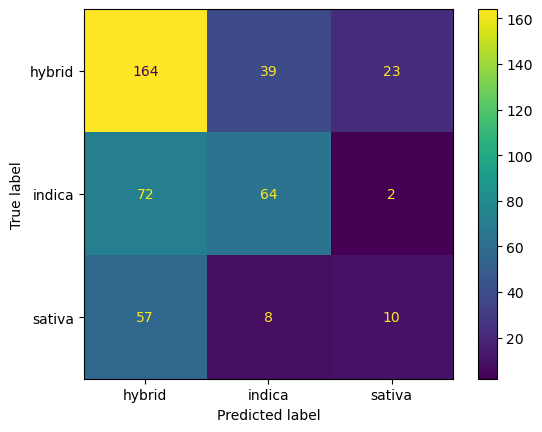

In [43]:
#get confusion matrix

# predict y's on X_test
y_pred = knn_pipeline.predict(X_test)

# generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
knn_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_pipeline.named_steps['knn_classifier'].classes_)
knn_cm.plot()


The metric used in this model was f1-macro. This is because our we have a multiclass variable as our response. Additionally, from our counts shown at the start of the lab, we can see that there is a BIG imbalance in between our classes (where hybrid is almost half of the observations). Becuase of this we want to use f1-macro as it will score for each class independently and then average them. This will give each class an equal weight.

**Q3**

Were your metrics better or worse than in Part One? Why? Which categories were most likely to get mixed up, according to the confusion matrices? Why?

Below will be the scores and the metrics used for each tuned model

Part 1 (accuracy as metric):

* LDA: 0.864236
* QDA: 0.851143
* SVC: 0.856746

Part 2 (f1-macro as the metric):

* LDA: 0.601772
* QDA: 0.6183
* KNN: 0.849676

The metrics did worse in part 2 than they did in part 1. The categories that were getting the most mixed up were between hybrid and the other two classes. It was pretty easy to identify the difference bet indica and sativa.

there are a few key variables (such as sleepy) that were essential in detmerining the class as indica, but other than that there weren't really any other vactors that could easily help us differentiate the three classes from eachother. As a result there is alot of confusion between hybrid and the other few variables.

As a result we can say that it is easier to distinguish sativa and indica from each other, but much more difficult to distinguish sativa, hybrid, and indica from eachother


**Part Three: Multiclass from Binary**

Consider two models designed for binary classification: SVC and Logistic Regression.

**Q1**

Fit and report metrics for **OvR** versions of the models. That is, for each of the two model types, create three models:

* Indica vs. Not Indica

* Sativa vs. Not Sativa

* Hybrid vs. Not Hybrid

In [44]:
#create new columns
cannabis_clean['is_indica'] = cannabis_clean['Type'] == 'indica'
cannabis_clean['is_sativa'] = cannabis_clean['Type'] == 'sativa'
cannabis_clean['is_hybrid'] = cannabis_clean['Type'] == 'hybrid'

#convert to binary
cannabis_clean['is_indica'] = cannabis_clean['is_indica'] * 1
cannabis_clean['is_sativa'] = cannabis_clean['is_sativa'] * 1
cannabis_clean['is_hybrid'] = cannabis_clean['is_hybrid'] * 1

Because OvR creates an imbalance for each target class (for example for indica is would be 500 to like 1500) we want to use f1 for all our models to help remove any biases which would help balance our precision/recalls

**Logistic Regression**

In [45]:
#logistic pipeline
lr_pipeline_logistic = Pipeline(
  [("preprocessing", ct),
  ("logistic_regression", LogisticRegression())]
).set_output(transform="pandas")

**Indica vs. Not Indica**

In [46]:
#variable selection
X = cannabis_clean.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = cannabis_clean["is_indica"]

In [47]:
#tune penalty parameter
Cs = {"logistic_regression__C": [0, .2, .4, .6, .8, 1]}

gscv = GridSearchCV(lr_pipeline_logistic, Cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.f

,logistic_regression__C,scores
2,0.4,0.639379
3,0.6,0.638802
4,0.8,0.638802
5,1.0,0.638240
1,0.2,0.637334


**Sativa vs. Not Sativa**

In [48]:
#variable selection
X = cannabis_clean.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = cannabis_clean["is_sativa"]

In [49]:
#tune penalty parameter
Cs = {"logistic_regression__C": [0, .2, .4, .6, .8, 1]}

gscv = GridSearchCV(lr_pipeline_logistic, Cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.f

,logistic_regression__C,scores
5,1.0,0.405023
4,0.8,0.402674
2,0.4,0.401218
3,0.6,0.400954
1,0.2,0.398352


**Hybrid vs. Not Hybrid**

In [50]:
#variable selection
X = cannabis_clean.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = cannabis_clean["is_hybrid"]

In [51]:
#tune penalty parameter
Cs = {"logistic_regression__C": [0, .2, .4, .6, .8, 1]}

gscv = GridSearchCV(lr_pipeline_logistic, Cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.f

,logistic_regression__C,scores
2,0.4,0.636773
3,0.6,0.636773
1,0.2,0.636697
4,0.8,0.636482
5,1.0,0.635356


**SVC**

In [52]:
#pipeline
lr_pipeline_support_vector_class = Pipeline(
  [("preprocessing", ct),
  #use kernel = 'linear' like from practice activity, still want to tune C
  ("support_vector_class", SVC(C = 0.1, kernel = 'linear'))]
).set_output(transform="pandas")

**Indica vs. Not Indica**

In [53]:
#variable selection
X = cannabis_clean.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = cannabis_clean["is_indica"]

In [54]:
#tune c
cs = {"support_vector_class__C": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_support_vector_class, cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,support_vector_class__C,scores
1,0.010,0.664868
2,0.100,0.661894
4,10.000,0.651658
5,100.000,0.651658
3,1.000,0.646918
0,0.001,0.430166


**Sativa vs. Not Sativa**

In [55]:
#variable selection
X = cannabis_clean.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = cannabis_clean["is_sativa"]

In [56]:
#tune c
cs = {"support_vector_class__C": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_support_vector_class, cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,support_vector_class__C,scores
4,10.000,0.380585
5,100.000,0.380585
3,1.000,0.375502
2,0.100,0.242799
0,0.001,0.000000
1,0.010,0.000000


**Hybrid vs. Not Hybrid**

In [57]:
#variable selection
X = cannabis_clean.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = cannabis_clean["is_hybrid"]

In [58]:
#tune c
cs = {"support_vector_class__C": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_support_vector_class, cs, cv = 5, scoring='f1')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,support_vector_class__C,scores
0,0.001,0.674469
1,0.010,0.672392
2,0.100,0.671603
3,1.000,0.643639
4,10.000,0.640934
5,100.000,0.640934


**Q2**

Which of the six models did the best job distinguishing the target category from the rest? Which did the worst? Does this make intuitive sense?

Below are the f1 scores for each of 6 tuned models shown above

Logistic Regression:

* Indica vs. Not Indica: 0.639379
* Sativa vs. Not Sativa: 0.405023
* Hybrid vs. Not Hybrid: 0.636773

SVC:

* Indica vs. Not Indica: 0.664868
* Sativa vs. Not Sativa: 0.380585
* Hybrid vs. Not Hybrid: 0.674469

Out of the six models, the SVC hybrid vs. Not hybrid model did the best (with an f1 score of 0.674469). The SVC Indica vs. Hybrid model did the worst (with an f1 score of 0.380585). This makes sense because both hybrid and indica have traits that have distinct them for the other classes. Because we are now dealing with a hybrid not hybrid situation we now have a binary response variable and because there are few variables that can help distinguish hybrid (such as focused) it is easier to determine. Additionally because the boundaries are better set, this meeans that SVC will out perform logistic regressions due to finding an optimal boundaries

Additionally, we can see that sativa vs. not sativa scored the lowest overall, this can be because due to the fact that there is a lot of characteristics shared between hybrid and sativa making it way harder to classifer sativa.

**Q3**

Fit and report metrics for OvO versions of the models. That is, for each of the two model types, create three models:

* Indica vs. Sativa

* Indica vs. Hybrid

* Hybrid vs. Sativa



In [59]:
#data creation
indica_sativa = cannabis_clean[(cannabis_clean['Type'] == 'indica') | (cannabis_clean['Type'] == 'sativa')]

indica_hybrid = cannabis_clean[(cannabis_clean['Type'] == 'indica') | (cannabis_clean['Type'] == 'hybrid')]

hybrid_sativa = cannabis_clean[(cannabis_clean['Type'] == 'hybrid') | (cannabis_clean['Type'] == 'sativa')]

**Logistic Regression**

**Indica vs. Sativa**

In [60]:
#variable selection
X = indica_sativa.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = indica_sativa["Type"]

In [61]:
#tune penalty parameter
Cs = {"logistic_regression__C": [0.1, .2, .4, .6, .8, 1]}

gscv = GridSearchCV(lr_pipeline_logistic, Cs, cv = 5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

,logistic_regression__C,scores
0,0.1,0.933871
1,0.2,0.932367
2,0.4,0.931175
3,0.6,0.930208
4,0.8,0.929762


**Indica vs. Hybrid**

In [62]:
#variable selection
X = indica_hybrid.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = indica_hybrid["Type"]

In [63]:
#tune penalty parameter
Cs = {"logistic_regression__C": [0, .2, .4, .6, .8, 1]}

gscv = GridSearchCV(lr_pipeline_logistic, Cs, cv = 5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 475, in fit
    self._final_estimator.f

,logistic_regression__C,scores
1,0.2,0.792955
2,0.4,0.792035
3,0.6,0.791826
4,0.8,0.791447
5,1.0,0.791372


**Hybrid vs. Sativa**

In [64]:
#variable selection
X = hybrid_sativa.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = hybrid_sativa["Type"]

In [65]:
#tune penalty parameter
Cs = {"logistic_regression__C": [0.1, .2, .4, .6, .8, 1]}

gscv = GridSearchCV(lr_pipeline_logistic, Cs, cv = 5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False).head()

,logistic_regression__C,scores
0,0.1,0.735203
1,0.2,0.734235
2,0.4,0.733376
3,0.6,0.732983
5,1.0,0.732765


**SVC**

**Indica vs. Sativa**

In [66]:
#variable selection
X = indica_sativa.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = indica_sativa["Type"]

In [67]:
#tune c
cs = {"support_vector_class__C": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_support_vector_class, cs, cv = 5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,support_vector_class__C,scores
0,0.001,0.939287
1,0.010,0.936046
2,0.100,0.932064
4,10.000,0.931850
5,100.000,0.931850
3,1.000,0.930950


**Indica vs. Hybrid**

In [68]:
#variable selection
X = indica_hybrid.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = indica_hybrid["Type"]

In [69]:
#tune c
cs = {"support_vector_class__C": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_support_vector_class, cs, cv = 5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,support_vector_class__C,scores
0,0.001,0.799317
1,0.010,0.796410
2,0.100,0.796248
3,1.000,0.793750
4,10.000,0.793433
5,100.000,0.793433


**Hybrid vs. Sativa**

In [70]:
#variable selection
X = hybrid_sativa.drop(["Type", "is_indica", "is_sativa", "is_hybrid"], axis = 1)
y = hybrid_sativa["Type"]

In [71]:
#tune c
cs = {"support_vector_class__C": [.001, .01, .1, 1, 10, 100]}

gscv = GridSearchCV(lr_pipeline_support_vector_class, cs, cv = 5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

params_df = pd.DataFrame(gscv_fitted.cv_results_['params'])

results_df = params_df.assign(scores=gscv_fitted.cv_results_['mean_test_score'])

results_df.sort_values(by = 'scores', ascending = False)

,support_vector_class__C,scores
4,10.000,0.733189
5,100.000,0.733189
0,0.001,0.732201
3,1.000,0.730349
1,0.010,0.730135
2,0.100,0.730037


**Q4**

Which of the six models did the best job distinguishing at differentiating the two groups? Which did the worst? Does this make intuitive sense?

Below are the f1 scores for each of 6 tuned models shown above

Logistic Regression:
* Indica vs. Sativa: 0.933871
* Indica vs. Hybrid: 0.792955
* Hybrid vs. Sativa: 0.735203

SVC:
* Indica vs. Sativa: 0.939287
* Indica vs. Hybrid: 0.799317
* Hybrid vs. Sativa: 0.733189

The best performing model was SVC indica vs. sativa. This makes the most sense because indica and sativa are the most well-defined classes (which we could also see with the high f1 scores from the previous part using OvR). Specifically it makes sense that SVC is a little better than the logistic regression model as it is better at finding the optimal boundaries

The worst performing model was SVC: hybrid vs. sativa. Because there is a lot of overlap between hybrid and the other strains (specifically sativa) it is harder to make a distinction between the two. For instance, a sativa and hybrid strain can be be described as energetic (overlap is variable classifications), while energetic is way less likely to be a feeling described for a indica strain.

This makes sense because just like the previous part we were able to see the same patterns while still being able to effectively build on the knowledge that there is better distinction between indica and sativa rather than sativa and hybrid

**Q5**

Suppose you had simply input the full data, with three classes, into the LogisticRegression function. Would this have automatically taken an “OvO” approach or an “OvR” approach?

What about for SVC?

Note: You do not actually have to run code here - you only need to look at sklearn’s documentation to see how these functions handle multiclass input.

Logistic Regression (default is OvR)
* logistic regression would create one binary class model for each possible class (like indica or not indica)
* Then for each model it would predict whether or not it belongs to its class or not
* then the final prediction used would be the class with the highest probability score

SVC (default is OvO)
* the SVC would create one binary class model for each possible pair of classes (like indica or sativa)
* then for each model it predicts which of the two classes each of the observations belongs to
* then the class with the highest score between all the classes is chosen

This is what I read from CHAT GPT aswell

OvR works better with Logistic Regression while SVC works between OvO. This is because SVC simplifies the optimization problem by breaking it into smaller pairwise tasks while OvR is better at determining whether or not something belongs in a single class.